In [29]:
# Allow notebook to import from sibling folder
import sys, os
import pandas as pd
sys.path.append(os.path.abspath(".."))
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns

In [30]:
#1. Load the Preprocessed data
df_formodel = pd.read_csv("../Data_Preprocessing/cleaned_data.csv")


In [31]:
# Select categorical columns
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

# Apply one-hot encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop_first avoids multicollinearity
encoded_features = encoder.fit_transform(df_formodel[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and concatenate encoded ones
df_numeric = df_formodel.drop(columns=categorical_cols + ['Loan_ID', 'Loan_Status'])  # Drop non-feature columns
df_processed = pd.concat([df_numeric, encoded_df], axis=1)

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_processed)  


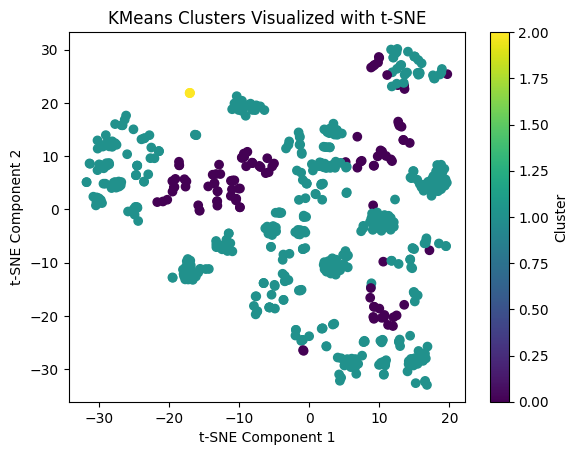

In [33]:
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_formodel['credit_risk_tier'] = kmeans.fit_predict(X_scaled)

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_scaled)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_formodel['credit_risk_tier'], cmap='viridis')
plt.title('KMeans Clusters Visualized with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

                  ApplicantIncome  LoanAmount  Credit_History
credit_risk_tier                                             
0                    10699.212963  223.453704        0.851852
1                     4261.606362  130.524851        0.838966
2                     6207.000000  139.333333        1.000000


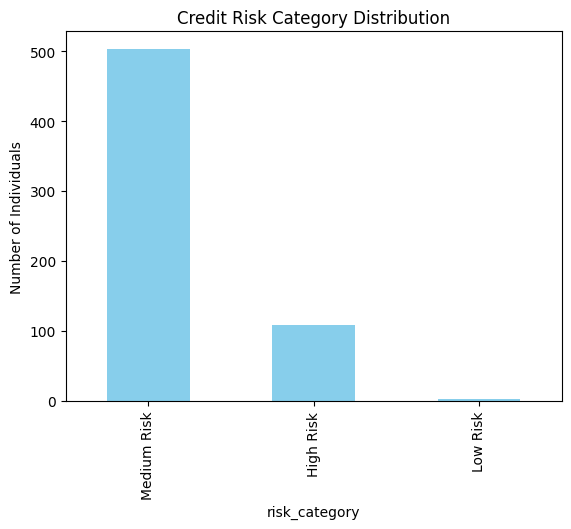

In [34]:
# Group by cluster and see feature averages
cluster_summary = df_formodel.groupby('credit_risk_tier')[['ApplicantIncome', 'LoanAmount', 'Credit_History']].mean()
print(cluster_summary)

# Based on your analysis above, map clusters to scores
# Example: let's say cluster 0 = high risk, 1 = medium, 2 = low
cluster_to_score = {
    0: 500,  # High Risk
    1: 650,  # Medium Risk
    2: 750   # Low Risk
}

df_formodel['pseudo_credit_score'] = df_formodel['credit_risk_tier'].map(cluster_to_score)

cluster_to_label = {
    0: 'High Risk',
    1: 'Medium Risk',
    2: 'Low Risk'
}

df_formodel['risk_category'] = df_formodel['credit_risk_tier'].map(cluster_to_label)

# Visualize the distribution of risk categories
df_formodel['risk_category'].value_counts().plot(kind='bar', title='Credit Risk Category Distribution', color='skyblue')
plt.ylabel("Number of Individuals")
plt.show()


C:\Users\ivych\AppData\Local\Temp\ipykernel_37500\2556730079.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_formodel, x='risk_category', y='Dependents', palette='viridis')


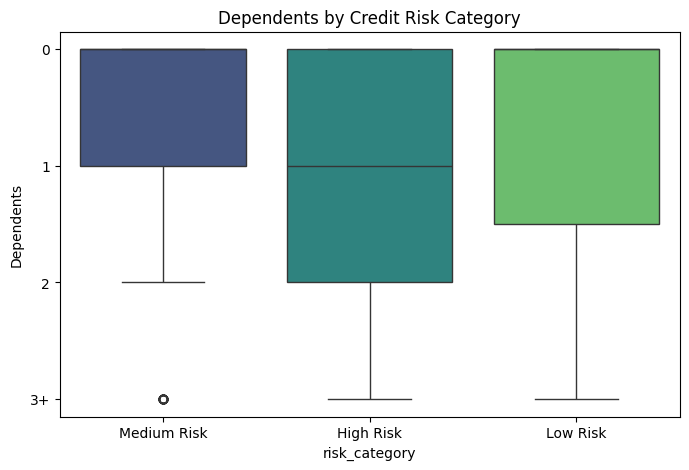

C:\Users\ivych\AppData\Local\Temp\ipykernel_37500\2556730079.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_formodel, x='risk_category', y='LoanAmount', palette='magma')


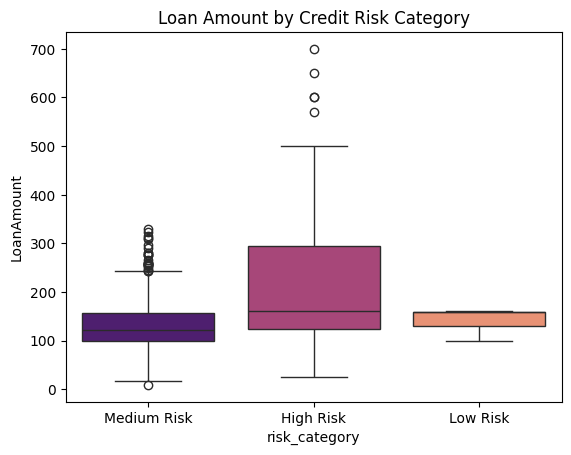

In [35]:

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_formodel, x='risk_category', y='Dependents', palette='viridis')
plt.title("Dependents by Credit Risk Category")
plt.show()

sns.boxplot(data=df_formodel, x='risk_category', y='LoanAmount', palette='magma')
plt.title("Loan Amount by Credit Risk Category")
plt.show()

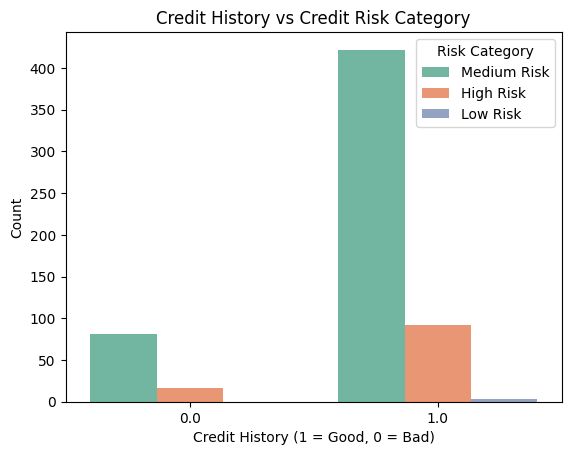

In [36]:
sns.countplot(data=df_formodel, x='Credit_History', hue='risk_category', palette='Set2')
plt.title("Credit History vs Credit Risk Category")
plt.xlabel("Credit History (1 = Good, 0 = Bad)")
plt.ylabel("Count")
plt.legend(title="Risk Category")
plt.show()

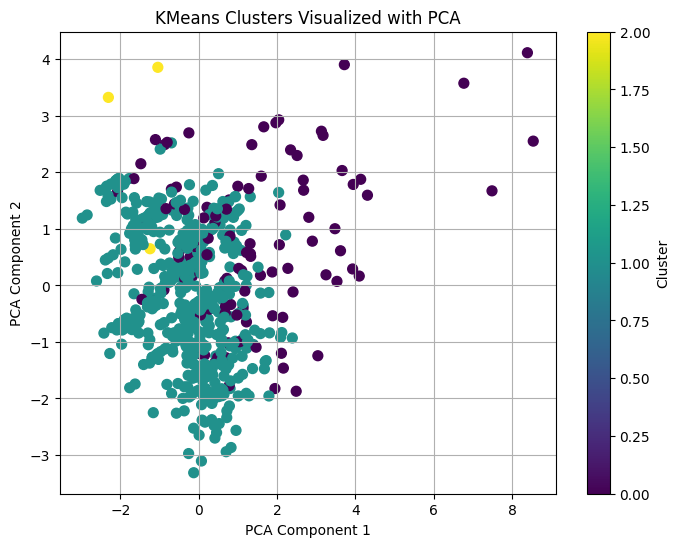

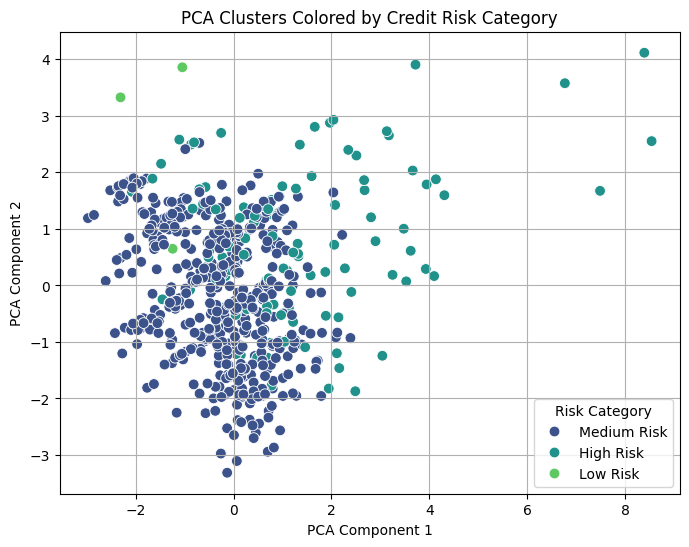

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2 for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_formodel['credit_risk_tier'], cmap='viridis', s=50)
plt.title('KMeans Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


# Assumes X_pca is your 2D PCA representation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_formodel['risk_category'], palette='viridis', s=60)
plt.title("PCA Clusters Colored by Credit Risk Category")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Risk Category')
plt.grid(True)
plt.show()